# Assignment 4
Training a neural named entity recognition (NER) tagger using BERT.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# additinal packages
import os,io
import numpy as np
import pandas as pd
from tabulate import tabulate
from random import sample,shuffle

from IPython.core.display import display, HTML

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Disabling autoscrolling for long output
# %%javascript
# IPython.OutputArea.prototype._should_scroll = function(lines) {
#     return false;
# }


In [ ]:
from google.colab import drive  
drive.mount(r'/content/drive/',force_remount=True) 

data_dir = os.getcwd() + '/' + 'drive/My Drive/Colab Notebooks/NLP/HW4'
data_dir

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


'/content/drive/My Drive/Colab Notebooks/NLP/HW4'

In this assignment you are required to build a full training and testing pipeline for a neural sequentail tagger for named entities, using BERT transformer, similar to assignment 3.

The dataset that you will be working on is called ReCoNLL 2003, which is a corrected version of the CoNLL 2003 dataset: https://www.clips.uantwerpen.be/conll2003/ner/

[Train data](https://drive.google.com/file/d/1hG66e_OoezzeVKho1w7ysyAx4yp0ShDz/view?usp=sharing)

[Dev data](https://drive.google.com/file/d/1EAF-VygYowU1XknZhvzMi2CID65I127L/view?usp=sharing)

[Test data](https://drive.google.com/file/d/16gug5wWnf06JdcBXQbcICOZGZypgr4Iu/view?usp=sharing)

As you can see, the annotated texts are labeled according to the IOB annotation scheme, for 3 entity types: Person, Organization, Location.

***(Already done in Assignment 3, so you may copy and paste it here)*** Write a funtion for reading the data from a single file (of the ones that are provided above). The function recieves a filepath and then it encodes every sentence individually using a pair of lists, one list contains the words and one list contains the tags. Each list pair will be added to a general list (data), which will be returned back from the function.

In [ ]:
def read_data(filepath):
    data = []
    # TODO... write your code accordingly 
    
    # read file - split into lines
    with open(data_dir + '/' + filepath,'r') as f:
        output = f.read().splitlines()

    # initial new sentence
    words = []
    tags  = []
    
    # run on all lines and create sentences based on this way --> data[i] = list(words):list(tags)
    for o in output:
        
        # for every new sentence
        if o=='':
            sentence = ' '.join(word for word in words)
            data.append((sentence,words,tags))
            tags=[]
            words=[]
            continue

        # for each line split into word:tag
        w,t = o.strip().split(' ') # did not lower case
        words.append(w)
        tags.append(t)

    # when files end, add last sentence (if it's not empty)
    if len(words):
        sentence = ' '.join(word for word in words)
        data.append((sentence,words,tags))
    
    return data

# # Google Drive
# train = read_data('https://drive.google.com/file/d/1hG66e_OoezzeVKho1w7ysyAx4yp0ShDz/view?usp=sharing')
# dev = read_data('https://drive.google.com/file/d/1EAF-VygYowU1XknZhvzMi2CID65I127L/view?usp=sharing')
# test = read_data('https://drive.google.com/file/d/16gug5wWnf06JdcBXQbcICOZGZypgr4Iu/view?usp=sharing')

train_data_,dev_data_,test_data_ = read_data('data/connl03_train.txt'), read_data('data/connl03_dev.txt'), read_data('data/connl03_test.txt')
len(train_data_),len(dev_data_),len(test_data_)

(1750, 250, 500)

In [ ]:
train_data_[10]

('- Financial negotiations between Lebanon and Pakistan .',
 ['-',
  'Financial',
  'negotiations',
  'between',
  'Lebanon',
  'and',
  'Pakistan',
  '.'],
 ['O', 'O', 'O', 'O', 'B-LOC', 'O', 'B-LOC', 'O'])

In [ ]:
# labels IDs
tag_values = []

for t in train_data_:
  tag_values.extend(t[2])

tag_values.append('PAD')

tag_values = list(set(labels))
tag2idx  = {l:i for i,l in enumerate(labels)}
idx2tag  = {i:l for i,l in enumerate(labels)}



Use Huggingface transformers:
https://github.com/huggingface/transformers

to process the data and train a BERT model (with a Linear layer on top) for NER.

Then, evaluate it on the Dev and Test data and report on results.

**Understand The Labels:** (`from doc`)
- "O",        Outside of a named entity
- "B-MISC",   Beginning of a miscellaneous entity right after another miscellaneous entity
- "I-MISC",   Miscellaneous entity
- "B-PER",    Beginning of a person's name right after another person's name
- "I-PER",    Person's name
- "B-ORG",    Beginning of an organisation right after another organisation
- "I-ORG",    Organisation
- "B-LOC",    Beginning of a location right after another location
- "I-LOC"     Location

As the `connl03 dataset` describe - the 'O' will be most of the tags, but I actualy "don't care" about it.  
Also, it's great that the train and dev has the same ratios between tags. 

Let's get to work...


# Installing [huggingface/transformers](https://github.com/huggingface/transformers)


In [ ]:
!pip install transformers

     |████████████████████████████████| 778kB 2.9MB/s 
     |████████████████████████████████| 3.0MB 15.6MB/s 
     |████████████████████████████████| 1.1MB 22.2MB/s 
     |████████████████████████████████| 890kB 42.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=c9b0c7a2f135454b0ac0ecc83be2eb4bbd7d88dcd129093dac3318c3dae6f2b5
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
# testing
from transformers import BertForTokenClassification

Due to the way BERT tagging works I understand why I have to use the built-in Tokenizer.

# Fine-tuning & pretrained BERT

I choosed to use Case Sensitive, due to additional information it will give for solving the NER task.  
Also, I choosed to use the 'base' version of BERT, due to my low computational power.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler
from transformers import BertForTokenClassification, BertTokenizer, BertConfig, AdamW, get_linear_schedule_with_warmup

torch.__version__

'1.5.1+cu101'

In [ ]:
from keras.preprocessing.sequence import pad_sequences

tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)


def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


MAX_LEN = 75
bs = 32


def prepare_data(data):
  sentences = [s[0] for s in data]
  labels = [l[2] for l in data]

  tokenized_texts_and_labels = [tokenize_and_preserve_labels(sent, labs) for sent, labs in zip(sentences, labels) ]
  tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
  tokenized_labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]


  input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

  tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                      maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                      dtype="long", truncating="post")


  attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

  return torch.tensor(input_ids).to(DEVICE),torch.tensor(attention_masks).to(DEVICE),torch.tensor(tags).to(DEVICE)


train_set = prepare_data(train_data_)
dev_set   = prepare_data(dev_data_)
test_set  = prepare_data(test_data_)


train_data = TensorDataset(train_set[0],train_set[1],train_set[2])
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(dev_set[0], dev_set[1], dev_set[2])
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

test_data = TensorDataset(test_set[0],test_set[1],test_set[2])
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=bs)


In [ ]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
).to(DEVICE)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [ ]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [ ]:
epochs = 30
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [ ]:
!pip install seqeval

  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=c5a106f6efd9aafa2acfdc560719a5201c5d760438bb96848db9df135b1c3e69
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval


In [ ]:
from seqeval.metrics import f1_score, accuracy_score

## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in range(epochs):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        
        # add batch to gpu
        batch = tuple(t.to(DEVICE) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,attention_mask=b_input_mask, labels=b_labels)

        # get the loss
        loss = outputs[0]

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # track train loss
        total_loss += loss.item()
        
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(DEVICE) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()

Average train loss: 0.5281996835361827
Validation loss: 0.7382817640900612
Validation Accuracy: 0.1704875686147885
Validation F1-Score: 0.01106567235987491

Average train loss: 0.5057943382046439
Validation loss: 0.7547184228897095
Validation Accuracy: 0.16984178237003553
Validation F1-Score: 0.011869436201780414

Average train loss: 0.4797641840848056
Validation loss: 0.7424586713314056
Validation Accuracy: 0.1704875686147885
Validation F1-Score: 0.012729003093028787

Average train loss: 0.4500200087373907
Validation loss: 0.788568839430809
Validation Accuracy: 0.1698955978904316
Validation F1-Score: 0.0125659415565171

Average train loss: 0.4174625808542425
Validation loss: 0.7839532271027565
Validation Accuracy: 0.17032612205360026
Validation F1-Score: 0.012639360877600906

Average train loss: 0.39170811663974414
Validation loss: 0.8037279322743416
Validation Accuracy: 0.17043375309439243
Validation F1-Score: 0.013401516487391994

Average train loss: 0.3671293776143681
Validation lo

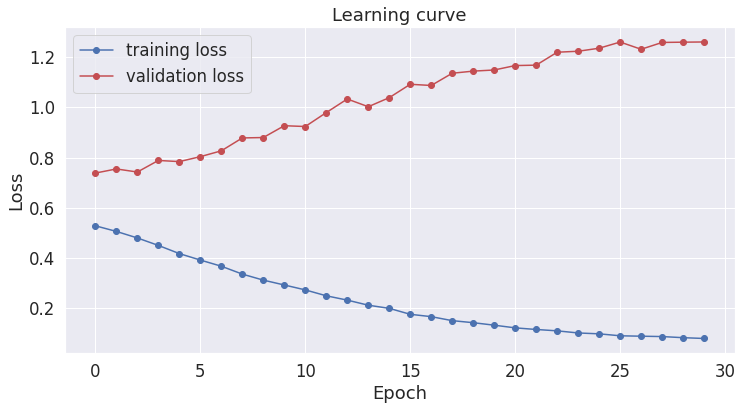

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
b_input_ids,b_input_mask,b_labels = train_data[0]

print(b_input_ids.unsqueeze(dim=0).shape,b_input_mask.unsqueeze(dim=0).shape,b_labels.unsqueeze(dim=0).shape)

with torch.no_grad():
  o = model(b_input_ids.unsqueeze(dim=0), token_type_ids=None,attention_mask=b_input_mask.unsqueeze(dim=0), labels=b_labels.unsqueeze(dim=0))
o[0]

torch.Size([1, 75]) torch.Size([1, 75]) torch.Size([1, 75])


tensor(0.0025, device='cuda:0')

In [ ]:
test_sentence = """
Mr. Trump’s tweets began just moments after a Fox News report by Mike Tobin, a 
reporter for the network, about protests in Minnesota and elsewhere. 
"""

tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).to(DEVICE)

with torch.no_grad():
    output = model(input_ids)

print(len(output),output[0].shape,input_ids.shape)
print(output)

label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))



1 torch.Size([1, 36, 8]) torch.Size([1, 36])
(tensor([[[ 5.4081, -0.9053, -2.2119,  0.5290, -1.5803, -1.8789, -0.5249,
          -0.4622],
         [-0.5369,  0.3398, -0.9251,  0.4707,  1.2477, -0.6602, -1.2491,
           1.3162],
         [ 1.9187,  0.4651, -1.8406,  1.7512,  0.1118, -1.3382, -1.3022,
          -0.4906],
         [ 3.5109, -0.6174, -2.1429,  1.2914,  0.2207, -2.0264, -0.8135,
          -0.9244],
         [ 1.5814, -0.3495, -2.6099,  1.5408, -0.3758, -0.7626,  0.4482,
          -0.8195],
         [ 1.4581,  0.1597, -2.9624,  0.8980,  0.0400, -1.4366,  1.5582,
          -1.0209],
         [ 2.4351,  0.5918, -2.6883, -0.2844, -0.8574, -1.0750,  1.3021,
          -1.0272],
         [ 2.6696,  0.3309, -2.3433,  0.4079, -0.7944, -0.9369,  0.1987,
          -0.8459],
         [ 2.2125,  0.2791, -2.6241,  0.2208, -0.5629, -1.0305,  1.4205,
          -1.0234],
         [ 1.9992, -0.2801, -2.5453,  1.3472, -0.8244, -1.0467,  0.5959,
          -0.9749],
         [ 1.8568,  0.25

**Good luck!**